> 为了对比原始DQN算法与9,10两节算法，在相同Pendulum-v1环境与超参数下，不同网络结构的性能差异，特此在本节展示原始DQN算法的性能

#### 倒立摆（Inverted Pendulum）环境（[gymnasium官方文档](https://gymnasium.farama.org/environments/classic_control/pendulum/))：
> 倒摆摆动问题基于控制理论中的经典问题。 该系统由一端连接到固定点的摆锤组成，另一端是自由的:
![pendulum环境示意图](Illustrations/pendulum环境.gif)

> 钟摆从一个随机位置开始，起始状态是 [-pi， pi] 中的随机角度和 [-1,1] 中的随机角速度
目标是在自由端施加扭矩以摆动它进入直立位置，在 200 个时间步长处截断
$\theta$以弧度为单位，弧度 = 角度 × $\frac{\pi}{180}$:
![pendulum坐标系](Illustrations/Pendulum坐标系.png)

> 环境的状态包括倒立摆角度的正弦值$sin\theta$，余弦值$cos\theta$，角速度$\dot{\theta}$；动作为对倒立摆施加的力矩torque:
![pendulum环境的状态空间](Illustrations/Pendulum环境的状态空间.png)
![pendulum环境的动作空间](Illustrations/Pendulum环境的动作空间.png)

> 奖励函数定义为：
$$r=-(theta^2+0.1*theta_-dt^2+0.001*torque^2)$$
可见，单次获得的最低奖励为 $(\text{圆周率}^2+0.1*8^2+0.001*2^2)=-16.2736044$, 而最大奖励为 0（钟摆直立，角速度为零，不施加力矩）

导入相关库：

In [1]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import gymnasium as gym

In [2]:
from utils.replay_buffer import ReplayBuffer
from utils.smoothing import moving_average

#### Q网络：

In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#### DQN算法:

In [4]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim 
        # Q 网络
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子（未来）
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            # 将列表转换为(batch_size, state_dim)的结构与网络传播兼容
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        # .view(-1, 1)转换为一个2D张量，以便与其他维度匹配并符合模型的输入要求
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)#转换为一个2D张量，以便与其他维度匹配并符合模型的输入要求
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # 当前Q值
        
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)  # 下个状态的最大Q值
        
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        # dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        loss = F.mse_loss(q_values, q_targets)  # 默认已经是 mean
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积, 非批量累积梯度任务，这里需要显式将梯度置为0
        loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

#### Env设置:

In [5]:
random.seed(0)       # 设置 Python 的随机种子
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='Pendulum-v1', entry_point='gymnasium.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='Pendulum', version=1, additional_wrappers=(), vector_entry_point=None)


#### 超参数设置(8,9节保持一致)：

In [6]:
# Agent
state_dim = env.observation_space.shape[0]  # 3
hidden_dim = 128
action_dim = 11                             # 神经网络输出11个离散动作             
lr = 1e-2
gamma = 0.98
epsilon = 0.01
target_update = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

num_episodes = 200
buffer_size = 5000  # 经验回放池的最大容量
replay_buffer = ReplayBuffer(buffer_size)  # 经验回收池
minimal_size = 1000   # 训练开始前回放池中最小的经验数量
batch_size = 64

> 由于 DQN 只能处理离散动作环境，环境中将连续的动作空间离散为 11 个动作。动作$[0,1,2,\ldots, 9, 10]$分别代表力矩为$[-2,-1.6,-1.2,\ldots, 1.2, 1.6, 2]$

In [7]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

#### 测试与训练：

In [8]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, info = env.reset(seed=0)  # 测试阶段(调整参数与对比算法)种子应固定; 训练阶段不固定，提高泛化能力
                done = False
                truncated = False
                while not (done or truncated):
                    action = agent.take_action(state)
                    #---------------------------
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 指数滑动平均（Exponential Moving Average, EMA）
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    #---------------------------
                    next_state, reward, done, truncated, _ = env.step([action_continuous])  # Box 类型 = 连续多维实数空间，需要传入NumPy数组类型
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

In [9]:
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s, episode=200, return=-124.808]


In [10]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
# 创建 DataFrame
df = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df.to_csv('DQN_8.5_returns_data.csv', index=False)

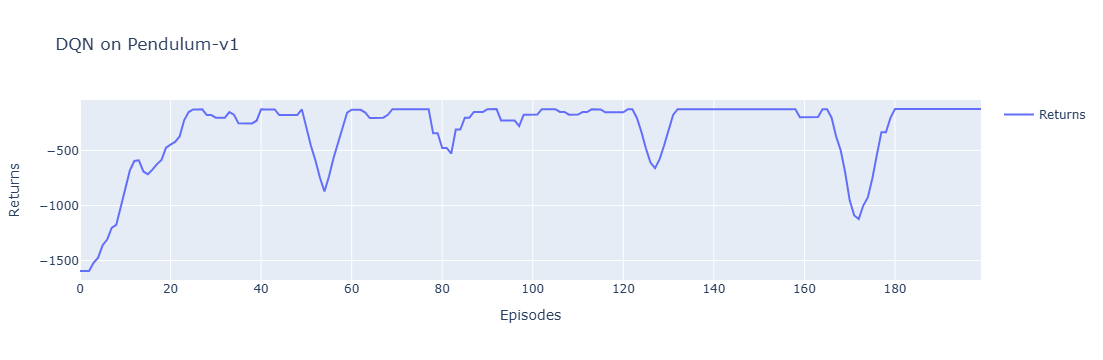

In [15]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('DQN_8.5_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='DQN on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

In [12]:
import pandas as pd
frames_list = list(range(len(max_q_value_list)))
# 创建 DataFrame
df = pd.DataFrame({'Frames': frames_list, 'Q value': max_q_value_list})
# 保存为 CSV 文件
df.to_csv('DQN_8.5_mv_returns_data.csv', index=False)

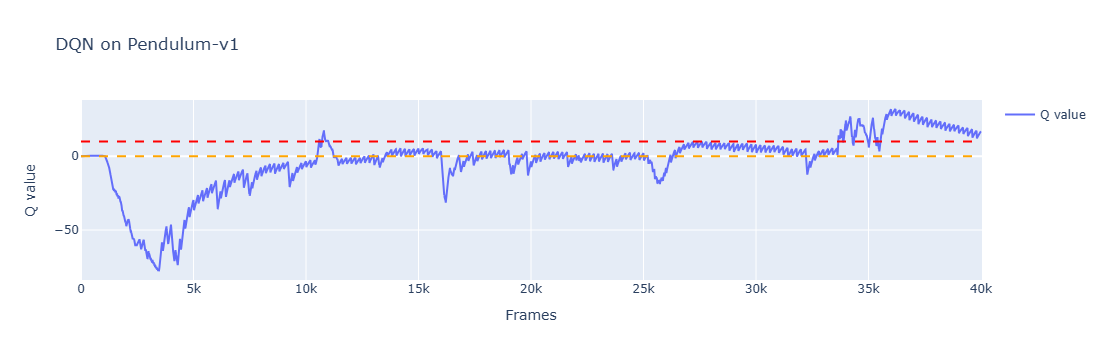

In [14]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('DQN_8.5_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Frames'], y=df['Q value'], mode='lines', name='Q value'))

# 添加水平线 y=0
fig.add_shape(type='line',
              x0=df['Frames'].min(), x1=df['Frames'].max(),
              y0=0, y1=0,
              line=dict(color='orange', dash='dash'))

# 添加水平线 y=10
fig.add_shape(type='line',
              x0=df['Frames'].min(), x1=df['Frames'].max(),
              y0=10, y1=10,
              line=dict(color='red', dash='dash'))

fig.update_layout(
    title='DQN on Pendulum-v1',
    xaxis_title='Frames',
    yaxis_title='Q value',
    showlegend=True
)
fig.show()

> 以上两张图，用于对比后续的改进算法 (**Dueling DQN** 和 **Double DQN**)